<img src="../imgs/head.png" style="width:1000px;">

# <center> Detección de Hate Speech en Twitter </center>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


%matplotlib inline

## <center> Dataset </center>

In [39]:
import pandas as pd
import tweepy
import jsonpickle
def tweets_to_df(path):
    
    tweets = list(open(path, 'rt'))
    
    text = []
    weekday = []
    month = []
    day = []
    hour = []
    hashtag = []
    url = []
    favorite = []
    reply = []
    retweet = []
    follower = []
    following = []
    user = []
    screen_name = []
    idrtw=[]

    for t in tweets:
        t = jsonpickle.decode(t)
        
        # Text
        text.append(t['full_text'])
        
        idrtw.append(t['id'])
        
        # Decompose date
        date = t['created_at']
        weekday.append(date.split(' ')[0])
        month.append(date.split(' ')[1])
        day.append(date.split(' ')[2])
        
        time = date.split(' ')[3].split(':')
        hour.append(time[0]) 
        
        # Has hashtag
        if len(t['entities']['hashtags']) == 0:
            hashtag.append(0)
        else:
            hashtag.append(1)
            
        # Has url
        if len(t['entities']['urls']) == 0:
            url.append(0)
        else:
            url.append(1)
            
        # Number of favs
        favorite.append(t['favorite_count'])
        
        # Is reply?
        if t['in_reply_to_status_id'] == None:
            reply.append(0)
        else:
            reply.append(1)       
        
        # Retweets count
        retweet.append(t['retweet_count'])
        
        # Followers number
        follower.append(t['user']['followers_count'])
        
        # Following number
        following.append(t['user']['friends_count'])
        
        # Add user
        user.append(t['user']['name'])

        # Add screen name
        screen_name.append(t['user']['screen_name'])
        
    d = {'text': text,
         'weekday': weekday,
         'month' : month,
         'day': day,
         'hour' : hour,
         'has_hashtag': hashtag,
         'has_url': url,
         'fav_count': favorite,
         'is_reply': reply,
         'retweet_count': retweet,
         'followers': follower,
         'following' : following,
         'user': user,
         'screen_name' : screen_name,
         'id' : idrtw
        }
    
    return pd.DataFrame(data = d)



In [40]:
buc1 = tweets_to_df('bucaramanga1.json')
buc2 = tweets_to_df('bucaramanga2.json')

In [41]:
PP = pd.concat([buc1, buc2])

In [45]:
df=pd.DataFrame({'text':PP.iloc[:,0]})
pd.set_option('display.max_colwidth', -1)
print(df.shape)
df.head()

(2381, 1)


,text
0,"¿Por qué el Dx no se hace solo, o porque la propuesta de intervención no se plantea solita? \nTodo le toca a uno que gonorrea."
1,RT @juanppitas: qué gonorrea este semestre
2,"Neas, que gonorrea estar con gripe y final de semestre, eso no es de Diosito."
3,"Bueno va tocar silenciar el nombre del paraco, porque ya me tienen harto con ese temita"
4,@petoricomelao2 @AndreaRamirezA_ Hágale hpta pero a puños como los hombres gonorrea


## <center> Preprocesamiento de los datos </center>

<img src="../imgs/preprocessing.png" style="width:800px;">

### Eliminación de ruido

In [23]:
import unicodedata
def remove_accents(string, accents=('COMBINING ACUTE ACCENT', 'COMBINING GRAVE ACCENT')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

In [7]:
#noacentos=pd.Series([remove_accents(i) for i in df['text']])
dfna=pd.DataFrame({'text':[remove_accents(i) for i in df['text']]})

In [8]:
##preprocesamiento del dataset original
clean1 = dfna["text"].str.replace((r'@[\w]*'), '')
clean2 = clean1.str.replace(r'RT', '')
clean = clean2.str.replace(r'[^a-zA-Z +^'']', '')


### Tokenización

La tokenización es el paso en el que se divide cadenas de texto más largas en piezas más pequeñas o tokens. 

In [9]:
tokens = []
for i in clean:
    tokens.append(nltk.word_tokenize(i))
    

### Eliminación de stopwords

In [10]:
stop_words= set(stopwords.words('spanish'))
wordnet_lemmatizer = WordNetLemmatizer()

lower_case = [[x.casefold() for x in sublst] for sublst in tokens]
cleanTweets = [[wordsub for wordsub in word if wordsub not in stop_words] for word in lower_case]


In [245]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [16]:
indx = np.random.randint(df.shape[0], size=10)
rand = []
clases = []
for i in indx:
    rand.append(clean[i])
    clases.append(df['text'][i])
print(rand)

[' jajajaja arepera ridicula', '  Mi primo de tres aosYo Di Uribe paraco hijueputa httpstcoZngVGMl', '   Otra prepago uribestia', '  Y este mamerto esta que salta porque se quedo sin mermelada Santos no volvera a la presidencia  asi que siga llorando', ' Lo unico que me preocupa es que se le haya mostrado la cara a algunas personas que fueron a decirle sus verdades al enano paraco', ' Sin vergenzasapatridaslame culos', ' Roy Barreras hablando de buen ejemplo es como si Garabito hablara del buen cuidado de los nios en esa imagen que muestra ademas de ser bien antigua se ve que hace falta una parte de la conversacion como siempre politiquero El camaleon Roy', 'Ya tu no me habla y yo no se que hacer mi conciencia me dice que tu no va a volver Jueputa anuel malparido lo amo jaja', '   Lo unico que me preocupa es que se le haya mostrado la cara a algunas personas que fueron a decirle sus v', ' Claro cerdo malparido como no fue ni su hijo ni su padre ni su hermano le vale mierda la vida de l

In [17]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
tfidf_prueba = tfidf_vectorizer.fit_transform((rand[0], rand[2]))
print(rand[0], '\n', rand[2])
print(tfidf_prueba.toarray())

 jajajaja arepera ridicula 
    Otra prepago uribestia
[[0.4472136  0.4472136  0.4472136  0.4472136  0.         0.
  0.4472136  0.        ]
 [0.         0.         0.         0.         0.57735027 0.57735027
  0.         0.57735027]]


### CountVectorizer

In [246]:
vectorized_data = count_vectorizer.fit_transform(clean)
#indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))


### Clasificación no supervisada

In [247]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3, n_init=30)  
kmeans.fit(vectorized_data) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=30, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [248]:
est=kmeans.predict(vectorized_data)
est

array([0, 2, 0, ..., 0, 0, 0], dtype=int32)

In [249]:
nosup = pd.DataFrame({'cluster':est,'tweet':clean})
sum(1*(nosup['cluster']==2))

111

In [268]:
nosup[nosup.cluster==1]

,cluster,tweet
6,1,Malparido clima parece Karate kid ponte la chaqueta quitate la chaqueta ponte encima mioAh no asi no era Jeje
7,1,Y por eso delegado de Estados Unidos la delegacion de la GLORIOSA UNION SOVIETICA decide vetar su resolucion Malparido
23,1,UribeColombiaEstaContigo rodeandote para que no te vayas a escapar malparido
28,1,Pobre malparido exclamo la dulce princesa
34,1,Hagame el malparido favor httpstcobqoLYxb
39,1,Deja de darle Rt a esa monda malparido que todos nos estamos viendo el partido pelao care verga
40,1,Mi novia me tiene dando vueltas por toda santa Marta buscando un malparido mango Vida sapa perra hijueputa
41,1,Mi mama Laura no vaya a pelear con su hermano Yo pirobo conteste ese hijueputa celular que tengo hambre malparido no hace un qlo por que no se va de esta casa que ya estorba
42,1,Yo pongo tantas canastas como aos le metan al malparido ahi esta mi UribeChallenge
43,1,Malparido clima parece Karate kid ponte la chaqueta quitate la chaqueta ponte encima mio ah no asi no era Jajaja


## DBSCAN

In [295]:
from sklearn.cluster import DBSCAN
DBS = DBSCAN(eps=.3, min_samples=5)
DBS.fit(vectorized_data) 

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [296]:
est2=DBS.labels_

In [297]:
nosup2 = pd.DataFrame({'cluster2':est2,'tweet':clean})
sum(1*(nosup2['cluster2']==1))

5

In [298]:
nosup2['cluster2'].unique()

array([-1,  0,  1])

# Semi-supervisado

In [303]:
>>> import numpy as np
>>> from sklearn import datasets
>>> from sklearn.semi_supervised import LabelPropagation
>>> label_prop_model = LabelPropagation()
>>> rng = np.random.RandomState(42)
>>> random_unlabeled_points = rng.rand(vectorized_data.toarray()) < 0.3
>>> labels = np.copy(iris.target)
>>> labels[random_unlabeled_points] = -1
>>> label_prop_model.fit(iris.data, labels)


LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [305]:
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(vectorized_data.toarray()) < 0.3)

TypeError: an integer is required

### Frecuencia de palabras para cada clase

In [302]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [347]:
wordshate=df[(df.clase == 0)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)
wordsoff=df[(df.clase == 1)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)
wordsneit=df[(df.clase == 2)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)

In [415]:
w=np.array(wordshate)[:,0]
c=np.array(wordshate)[:,1]

w1=np.array(wordsoff)[:,0]
c1=np.array(wordsoff)[:,1]

w2=np.array(wordsneit)[:,0]
c2=np.array(wordsneit)[:,1]

In [416]:
d = pd.DataFrame({'word': w,
                  'valor': [int(x) for x in c]})
d1 = pd.DataFrame({'word': w1,
                  'valor': [int(x) for x in c1]})
d2 = pd.DataFrame({'word': w2,
                  'valor': [int(x) for x in c2]})


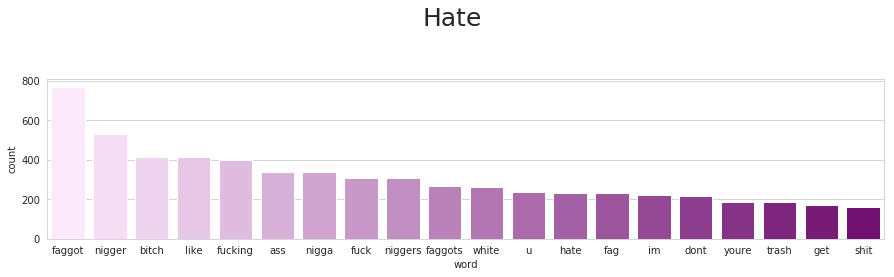

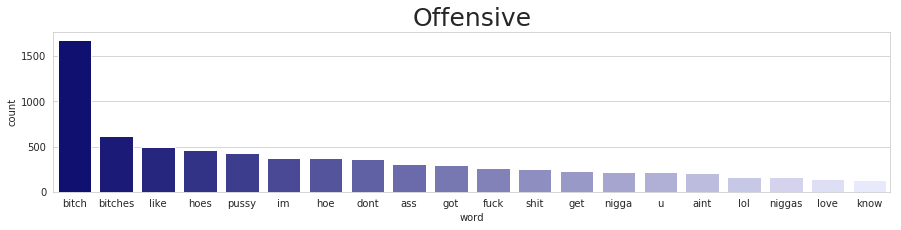

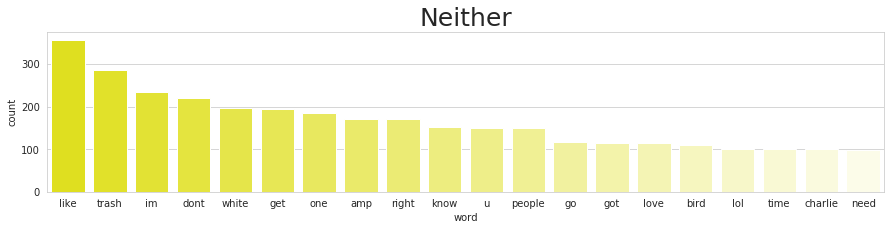

In [451]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
fig.suptitle('Hate', fontsize=25)
ax = sns.barplot(data=d, x= "word", y = "valor", palette= sns.light_palette("purple",n_colors=20, reverse=False))
ax.set(ylabel = 'count')
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
ax = sns.barplot(data=d1, x= "word", y = "valor",palette=sns.light_palette("navy",n_colors=20, reverse=True))
ax.set(ylabel = 'count')
plt.title("Offensive", fontsize=25)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(3,1,3)
ax = sns.barplot(data=d2, x= "word", y = "valor",palette=sns.light_palette("yellow",n_colors=20, reverse=True))
ax.set(ylabel = 'count')
plt.title("Neither", fontsize=25)
plt.show()